In [9]:
import cell
import grid
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer


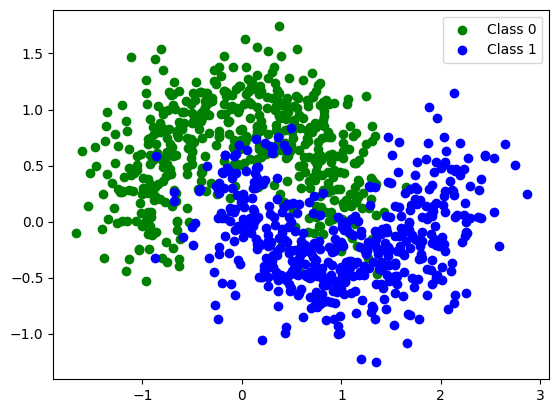

In [12]:
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)
encoder = KBinsDiscretizer(n_bins=12, encode='ordinal', strategy='uniform')
X_binned = encoder.fit_transform(X)
X_encoded = np.zeros((X.shape[0], 12 * X.shape[1]))

for i in range(X.shape[1]):
    for j in range(12):
        X_encoded[:, i*12 + j] = (X_binned[:, i] == j).astype(int)

plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='green', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
plt.title('')
plt.legend()
plt.show()


In [19]:
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
lr_model = LogisticRegression()
lr_model.fit(X_train_encoded, y_train)
y_pred_linear = lr_model.predict(X_test_encoded)
linear_accuracy_encode = accuracy_score(y_test, y_pred_linear)

mlp_model = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)
mlp_model.fit(X_train_encoded, y_train)
y_pred_nn = mlp_model.predict(X_test_encoded)
nn_accuracy_encode = accuracy_score(y_test, y_pred_nn)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_linear = lr_model.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_pred_linear)

mlp_model = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_nn = mlp_model.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred_nn)

print(f"Logistic Regression Accuracy: {linear_accuracy:.4f}")
print(f"MLP Accuracy: {nn_accuracy:.4f}")
print(f"Logistic Regression Accuracy - Encoded data: {linear_accuracy_encode:.4f}")
print(f"MLP Accuracy - Encoded data: {nn_accuracy_encode:.4f}")

Logistic Regression Accuracy: 0.8533
MLP Accuracy: 0.9033
Logistic Regression Accuracy - Encoded data: 0.9067
MLP Accuracy - Encoded data: 0.9233


In [22]:
# Create 35x35 grid and randomize
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
plate = grid.Grid(24)
plate.randomize_plate(percent_nor_fill=0.5, percent_wire_fill=0.5)

train_outputs = []
for x_i in X_train_encoded:
    plate.inputs = x_i
    plate.update_plate()
    tmp_outputs = plate.set_outputs()
    train_outputs.append([int(output) for output in tmp_outputs if output != -1])
    plate.reset_plate_values()

test_outputs = []
for x_i in X_test_encoded:
    plate.inputs = x_i
    plate.update_plate()
    tmp_outputs = plate.set_outputs()
    test_outputs.append([int(output) for output in tmp_outputs if output != -1])
    plate.reset_plate_values()

linear_clf = LogisticRegression()
linear_clf.fit(train_outputs, y_train)
y_pred_RC = linear_clf.predict(test_outputs)
linear_accuracy = accuracy_score(y_test, y_pred_RC)

print(f"Logistic Regression Accuracy: {linear_accuracy:.4f}")

Logistic Regression Accuracy: 0.7667


In [41]:
# Test varying percentages of nor gates and wires
X_train_encoded, X_temp_encoded, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.4, random_state=42)
X_val_encoded, X_test_encoded, y_val, y_test = train_test_split(X_temp_encoded, y_temp, test_size=0.5, random_state=42)
percentages = np.arange(0.1, 0.7, 0.1)
best_accuracy = 0
best_nor_percent = 0
best_wire_percent = 0

for nor_percent in percentages:
    for wire_percent in percentages:
        total_percent = nor_percent + wire_percent
        if 0.5 <= total_percent <= 1.0:
            plate = grid.Grid(24)
            plate.randomize_plate(percent_nor_fill=nor_percent, percent_wire_fill=wire_percent)

            train_outputs = []
            for x_i in X_train_encoded:
                plate.inputs = x_i
                plate.update_plate()
                tmp_outputs = plate.set_outputs()
                train_outputs.append([int(output) for output in tmp_outputs if output != -1])
                plate.reset_plate_values()

            val_outputs = []
            for x_i in X_val_encoded:
                plate.inputs = x_i
                plate.update_plate()
                tmp_outputs = plate.set_outputs()
                if len(tmp_outputs) < 24:
                    tmp_outputs = np.append(tmp_outputs, 0)
                val_outputs.append([int(output) for output in tmp_outputs if output != -1])
                plate.reset_plate_values()


            linear_clf = LogisticRegression()
            linear_clf.fit(train_outputs, y_train)
            y_pred_val = linear_clf.predict(val_outputs)
            val_accuracy = accuracy_score(y_val, y_pred_val)
            print(f"NOR %: {nor_percent:.2f}, Wire %: {wire_percent:.2f}, Accuracy: {val_accuracy:.4f}")
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_nor_fill = nor_percent
                best_wire_fill = wire_percent

plate.randomize_plate(percent_nor_fill=best_nor_fill, percent_wire_fill=best_wire_fill)

test_outputs = []
for x_i in X_test_encoded:
    plate.inputs = x_i
    plate.update_plate()
    tmp_outputs = plate.set_outputs()
    test_outputs.append([int(output) for output in tmp_outputs if output != -1])
    plate.reset_plate_values()

y_pred_test = linear_clf.predict(test_outputs)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Best NOR Fill: {best_nor_fill:.2f}, Best Wire Fill: {best_wire_fill:.2f}")
print(f"Validation Accuracy with Best Combination: {best_accuracy:.4f}")
print(f"Test Accuracy with Best Combination: {test_accuracy:.4f}")


NOR %: 0.10, Wire %: 0.40, Accuracy: 0.5650
NOR %: 0.10, Wire %: 0.50, Accuracy: 0.5300
NOR %: 0.10, Wire %: 0.60, Accuracy: 0.6100
NOR %: 0.20, Wire %: 0.30, Accuracy: 0.6150
NOR %: 0.20, Wire %: 0.40, Accuracy: 0.5300
NOR %: 0.20, Wire %: 0.50, Accuracy: 0.5300
NOR %: 0.20, Wire %: 0.60, Accuracy: 0.7600
NOR %: 0.30, Wire %: 0.20, Accuracy: 0.4850
NOR %: 0.30, Wire %: 0.30, Accuracy: 0.5900
NOR %: 0.30, Wire %: 0.40, Accuracy: 0.5750
NOR %: 0.30, Wire %: 0.50, Accuracy: 0.6600
NOR %: 0.30, Wire %: 0.60, Accuracy: 0.6350
NOR %: 0.40, Wire %: 0.10, Accuracy: 0.5300
NOR %: 0.40, Wire %: 0.20, Accuracy: 0.5300
NOR %: 0.40, Wire %: 0.30, Accuracy: 0.7050
NOR %: 0.40, Wire %: 0.40, Accuracy: 0.5300
NOR %: 0.40, Wire %: 0.50, Accuracy: 0.7000
NOR %: 0.40, Wire %: 0.60, Accuracy: 0.8900
NOR %: 0.50, Wire %: 0.10, Accuracy: 0.5300
NOR %: 0.50, Wire %: 0.20, Accuracy: 0.6050
NOR %: 0.50, Wire %: 0.30, Accuracy: 0.6300
NOR %: 0.50, Wire %: 0.40, Accuracy: 0.6300
NOR %: 0.50, Wire %: 0.50, Accur

In [33]:
test_outputs

[[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,

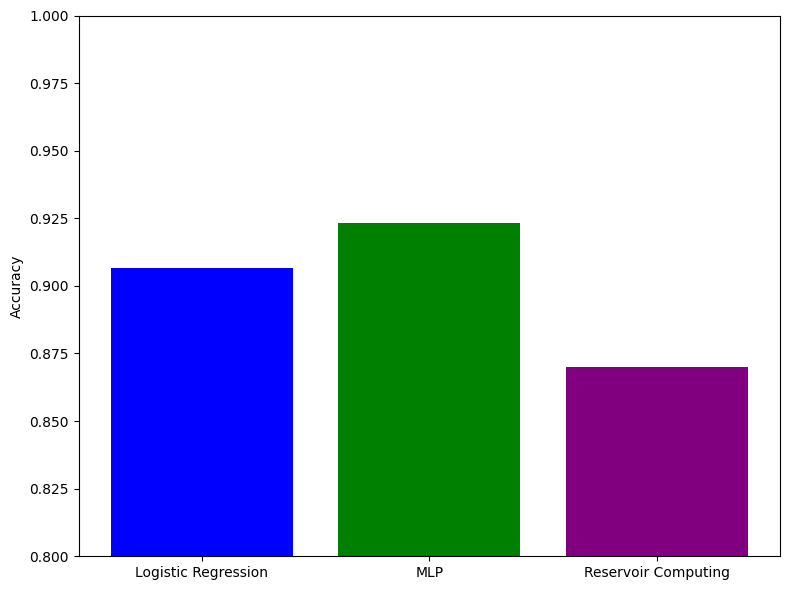

In [26]:
import matplotlib.pyplot as plt

linear_accuracy = 0.9067
nn_accuracy = 0.9233
reservoir_accuracy = 0.87

plt.figure(figsize=(8, 6))
classifiers = ['Logistic Regression', 'MLP', 'Reservoir Computing']
accuracies = [linear_accuracy, nn_accuracy, reservoir_accuracy]
plt.bar(classifiers, accuracies, color=['blue', 'green', 'purple'])
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

